## This code has been written to plot graphs for the rays summer school project on ice nucleation 

In [13]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py
import pandas as pd
import os
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator

In [14]:
# Read the file that was saved previously using nucleation script
file_error = np.loadtxt('/Volumes/harddrive/210630/Finding_droplets-master/Examples/Results_MC/2021_raysforexcellence.txt', skiprows = 1)
J_err_high = file_error[:,-1]
J_err_low = file_error[:,-2]
J = file_error[:,-3]
Temperature_err_high = file_error[:,-4]
Temperture_err_low = file_error[:,-5]
Temperature = file_error[:,-6]

In [15]:
# insert the errors calculated using Wilson method 95% confidence

## These are the errors for the laser-induced experiment
frac_lower = np.array([0,0.,0.012848990357890114,0.0114001834615757,0.022931616634749855,0.007716467001661794])
frac_higher = np.array([0.0741026511527422,0.13319649395317873,0.15455775936884852,0.09347441309261774,0.17856874432803596,0.20991586512458996])

<IPython.core.display.Javascript object>


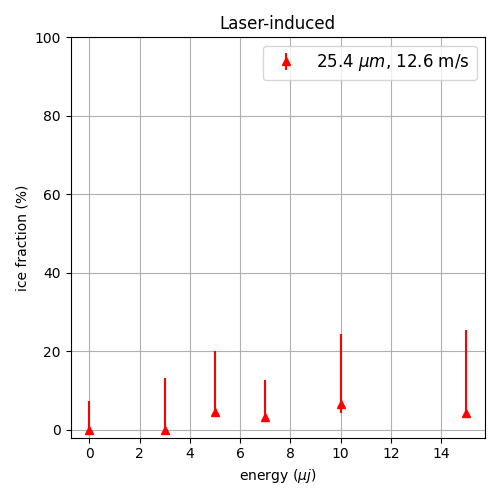

In [16]:
ice_fraction = [0,0,4.651162791,3.333333333,6.666666667,4.347826087]
energy = [0,3,5,7,10,15]

plt.figure(figsize=[5,5])
plt.errorbar(energy, ice_fraction, yerr=[frac_lower*100, frac_higher*100], fmt='r^', ms=6, label='25.4 $\mu m$, 12.6 m/s')
#plt.plot(energy, ice_fraction, 'ro:', label = '25.4 $\mu m$')
plt.xlabel('energy $(\mu j$)')
plt.ylabel('ice fraction (%)')
#plt.savefig('/Users/niloo/Desktop/iceshapes.eps', format ='eps')
plt.legend(loc='upper right', fontsize=12)
plt.title('Laser-induced')
plt.ylim(-2,100)
plt.grid()
plt.tight_layout()
plt.savefig('/Volumes/harddrive/codes_rays/final_figs/energy_vs_fraction.png', format='png')
plt.show()

In [17]:
fraction_low = np.array([0,0,0,0.0016212895797844723,0.0022666734428713267,0.0022099186183062243,0.0,0.012829808051235146,0.1492048880971003])
fraction_high = np.array([0.010826239088088881,0.02480987021575597,0.026522766939884673,0.05014685280742024,0.06911023057660043,0.06746432423965451,0.0741026511527422,0.042765545104801954,0.3878464374792707])

In [20]:
f=h5py.File('/Volumes/harddrive/codes_rays/temperature_calib/t_calib_20.h5','r')
f1=h5py.File('/Volumes/harddrive/codes_rays/temperature_calib/t_calib_27.h5','r')
f.keys()
f['data'].keys()
Tave = f['data/Tave'][:]
t = f['data/time'][:]

Tave1 = f1['data/Tave'][:]
t1 = f1['data/time'][:]

<IPython.core.display.Javascript object>


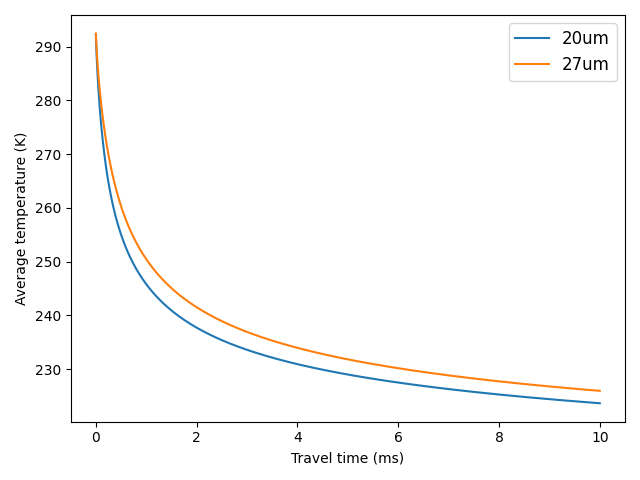

In [21]:
# plot the cooling curve that estimate the temperature using the equation in the report

plt.figure()
plt.plot(t*1000, Tave, label ='20um')
plt.plot(t1*1000, Tave1, label ='27um')
plt.xlabel('Travel time (ms)')
plt.ylabel('Average temperature (K)')
#plt.savefig('/Users/niloo/Desktop/iceshapes.eps', format ='eps')
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

In [22]:
def read_hdf5(path, filename):
    f = h5py.File('{0}/{1}'.format(path, filename), 'r')
    return f['data']['time'], f['data']['Tave']

def T_at_distance(distance, velocity, droplet_size, T_function):
    '''Distance in m, velocity in m/s, droplet_size is diameter in micrometer'''
    time = np.divide(distance, velocity)
    temperature = T_function([droplet_size, time], method='linear')
    return temperature

def T_at_time(time, droplet_size, T_function):
    '''Time in s, droplet_size is diameter in micrometer'''
    temperature = T_function([droplet_size, time], method='linear')
    return temperature


#These are the sizes that are in the folder of hdf5 files. Must have the same timesteps
sizes = [3, 5, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

#sizes is the x 
x = sizes

# y is the timesteps, and this is taken from the file t_calib_22.h5
time, _ = read_hdf5('/Volumes/harddrive/codes_rays/temperature_calib/', 't_calib_18.h5')
y = list(time[:])  

#Create an empy matrix with the size of the sizes and times
temperatures = np.zeros([len(x), len(y)])

#Filling the matrix with actual values measured.
for size_index, size_value in enumerate(sizes):
    _, temperatures[size_index] = read_hdf5(
        '/Volumes/harddrive/codes_rays/temperature_calib/', 't_calib_{0}.h5'.format(size_value))

# This is a function returned by the RegularGridInterpolator
#interpolate_T = interp2d(xx, yy, temperatures, kind='linear',bounds_error=True)
interpolate_T = RegularGridInterpolator((x, y), temperatures)


In [23]:
diameter = 25.7*10E-6 #m
Volume = (4*np.pi/3)*(diameter/2)**3
flow_rate = (68.5*10E-6)/60*10E-3 #l/s
actual_frequency = flow_rate/Volume
spacing = 95.7*10E-6 #m
velocity = spacing * actual_frequency #m/s
distance = np.array([10,20,30,35,40,45,50,55,60])#mm
time = distance*10**-3/velocity #s
#temperature = T_at_time(time, 25.7, interpolate_T)
temperatures = [T_at_time(x, 25.7, interpolate_T) for x in time]
fraction = np.array([0,0,0,0.917431193,1.282051282,1.25,0,2.352941176,25])

<IPython.core.display.Javascript object>


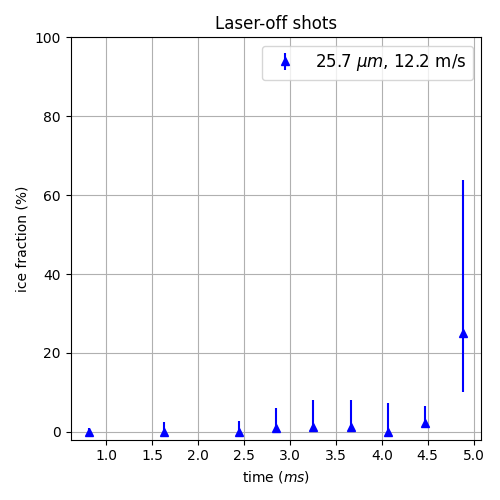

In [24]:
plt.figure(figsize=[5,5])
plt.errorbar(time*1000, fraction, yerr=[fraction_low*100, fraction_high*100], fmt='b^', ms=6, label='25.7 $\mu m$, 12.2 m/s')
#plt.plot(time*1000, fraction, 'ro:', label = '25.7 $\mu m$')
plt.xlabel('time ($ms$)')
plt.ylabel('ice fraction (%)')
plt.ylim(-2, 100)
plt.grid()
plt.title('Laser-off shots')
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig('/Volumes/harddrive/codes_rays/final_figs/time_vs_fraction.png', format ='png')
plt.show()

<IPython.core.display.Javascript object>


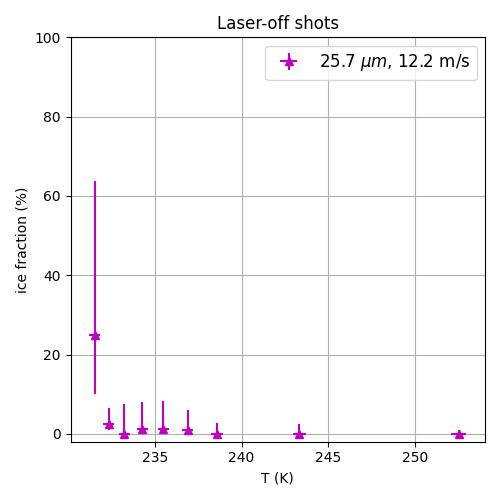

In [26]:
plt.figure(figsize=[5,5])
plt.errorbar(Temperature, fraction, yerr=[fraction_low*100, fraction_high*100], xerr=[Temperture_err_low,Temperature_err_high], fmt='m^', ms=6, label='25.7 $\mu m$, 12.2 m/s')
#plt.plot(time*1000, fraction, 'ro:', label = '25.7 $\mu m$')
plt.xlabel('T (K)')
plt.ylabel('ice fraction (%)')
plt.ylim(-2, 100)
plt.grid()
plt.title('Laser-off shots')
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig('/Volumes/harddrive/codes_rays/final_figs/temperature_vs_fraction.png', format ='png')
plt.show()

<IPython.core.display.Javascript object>


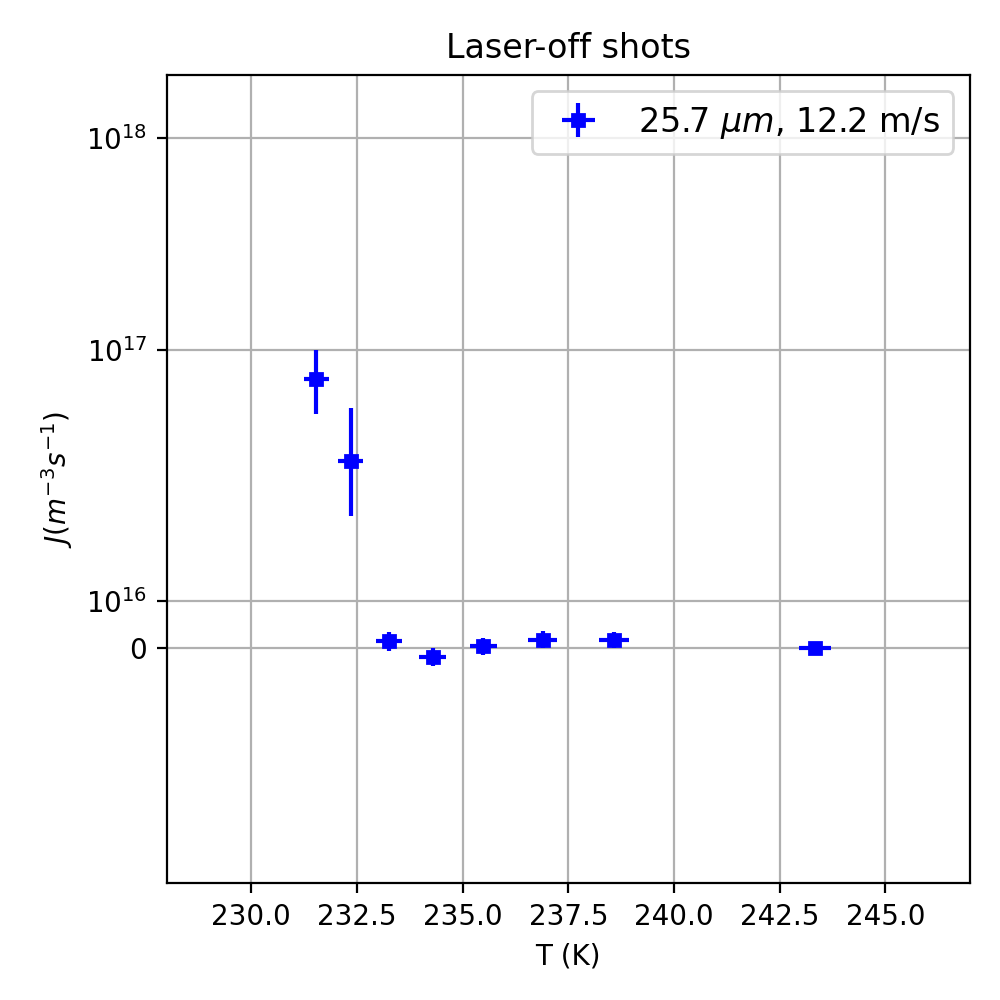

In [3]:
plt.figure(figsize=[5,5])
ax=plt.gca()
ax.errorbar(Temperature, J, yerr=[J_err_low, J_err_high], xerr=[Temperture_err_low,Temperature_err_high], fmt='bs', ms=4,label='25.7 $\mu m$, 12.2 m/s')
#plt.plot(time*1000, fraction, 'ro:', label = '25.7 $\mu m$')
ax.set_xlabel('T (K)')
ax.set_ylabel('$J (m^{-3}s^{-1})$')
ax.set_yscale('symlog', linthresh=5e16)
ax.set_ylim(bottom=-0.5e17,top=2e18)
ax.set_xlim(left=228,right=247)

ax.grid()
#plt.savefig('/Users/niloo/Desktop/iceshapes.eps', format ='eps')
plt.title('Laser-off shots')
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.savefig('/Volumes/harddrive/codes_rays/final_figs/J_vs_T.png', format ='png')
plt.show()